In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


Load the datasets

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


Step 1: Feature Engineering

In [7]:
# Aggregate transaction data for each customer
transaction_agg = transactions.groupby("CustomerID").agg(
    total_transactions=("TransactionID", "count"),
    total_value=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    preferred_category=("ProductID", lambda x: x.mode()[0])  # Most frequent product category
).reset_index()

In [8]:
# Merge aggregated transaction data with customer profiles
data = pd.merge(customers, transaction_agg, on="CustomerID", how="inner")

In [9]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ["total_transactions", "total_value", "avg_transaction_value"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

Step 2: Clustering Algorithm

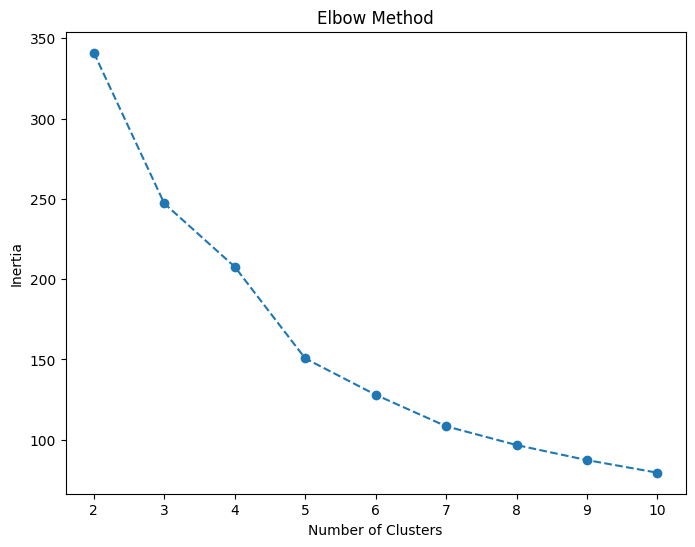

In [10]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data[numerical_features])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker="o", linestyle="--")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [13]:
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data["cluster"] = kmeans.fit_predict(data[numerical_features])

# Evaluate clustering performance
silhouette_avg = silhouette_score(data[numerical_features], data["cluster"])
db_index = davies_bouldin_score(data[numerical_features], data["cluster"])
print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

Silhouette Score: 0.35
Davies-Bouldin Index: 0.85


Step 3: Visualization

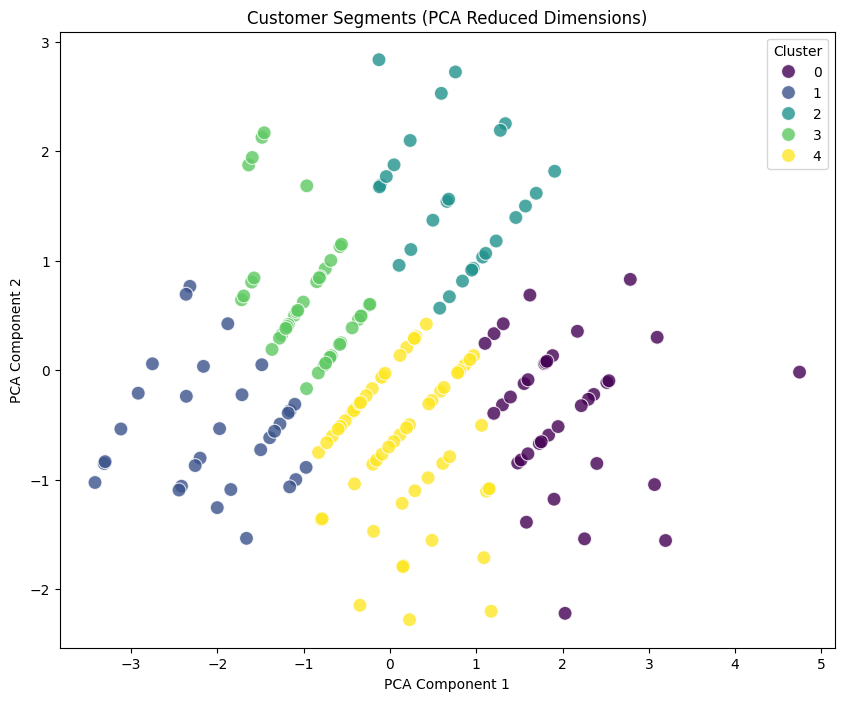

In [14]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data[numerical_features])
data["pca_1"] = data_pca[:, 0]
data["pca_2"] = data_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="viridis",
    data=data,
    s=100,
    alpha=0.8
)
plt.title("Customer Segments (PCA Reduced Dimensions)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


Step 4: Key Findings and Cluster Profiles

In [15]:
cluster_profiles = data.groupby("cluster").agg(
    total_customers=("CustomerID", "count"),
    avg_total_transactions=("total_transactions", "mean"),
    avg_total_value=("total_value", "mean"),
    avg_transaction_value=("avg_transaction_value", "mean"),
    top_preferred_category=("preferred_category", lambda x: x.mode()[0])
)

print("\nCluster Profiles:")
print(cluster_profiles)

#Save cluster profiles to a CSV
cluster_profiles.to_csv("Cluster_Profiles.csv")


Cluster Profiles:
         total_customers  avg_total_transactions  avg_total_value  \
cluster                                                             
0                     36                1.305979         1.514693   
1                     31               -0.952952        -1.281078   
2                     27               -0.416823         0.470492   
3                     41               -0.901284        -0.713056   
4                     64                0.480206         0.026821   

         avg_transaction_value top_preferred_category  
cluster                                                
0                     0.474576                   P006  
1                    -1.329192                   P022  
2                     1.594628                   P020  
3                     0.180560                   P003  
4                    -0.411527                   P001  


In [16]:
# Business Insights
print("\nBusiness Insights:")
for cluster, row in cluster_profiles.iterrows():
    print(f"Cluster {cluster}:")
    print(f"  - Total Customers: {row['total_customers']}")
    print(f"  - Avg. Total Transactions: {row['avg_total_transactions']:.2f}")
    print(f"  - Avg. Total Value: {row['avg_total_value']:.2f}")
    print(f"  - Avg. Transaction Value: {row['avg_transaction_value']:.2f}")
    print(f"  - Top Preferred Category: {row['top_preferred_category']}\n")



Business Insights:
Cluster 0:
  - Total Customers: 36
  - Avg. Total Transactions: 1.31
  - Avg. Total Value: 1.51
  - Avg. Transaction Value: 0.47
  - Top Preferred Category: P006

Cluster 1:
  - Total Customers: 31
  - Avg. Total Transactions: -0.95
  - Avg. Total Value: -1.28
  - Avg. Transaction Value: -1.33
  - Top Preferred Category: P022

Cluster 2:
  - Total Customers: 27
  - Avg. Total Transactions: -0.42
  - Avg. Total Value: 0.47
  - Avg. Transaction Value: 1.59
  - Top Preferred Category: P020

Cluster 3:
  - Total Customers: 41
  - Avg. Total Transactions: -0.90
  - Avg. Total Value: -0.71
  - Avg. Transaction Value: 0.18
  - Top Preferred Category: P003

Cluster 4:
  - Total Customers: 64
  - Avg. Total Transactions: 0.48
  - Avg. Total Value: 0.03
  - Avg. Transaction Value: -0.41
  - Top Preferred Category: P001

